In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from datetime import date
from datetime import datetime
import surprise
from sklearn.preprocessing import StandardScaler
from surprise import SVD
from surprise import Reader, Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from surprise.dataset import DatasetAutoFolds
from surprise import accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import math
from sklearn.metrics import silhouette_samples, silhouette_score

#### 1. 데이터 로드
***
###### > user_info = Kaggle(Customer Personality Analysis)의 데이터 특성 중, 실제 컬리에서 얻을 수 있다고 판단된 것들만 사용함
###### > click_df = 고객마다의 상품 데이터에 대한 클릭 횟수를 0~10회로 가정함.


In [11]:
user_info = pd.read_csv('./user_info_v3.csv')
click_df = pd.read_csv('./click.csv', encoding = 'ANSI')
user_info.drop(columns = ['Unnamed: 0'], inplace = True)
user_info

,ID,Year_Birth,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,NumDealsPurchases,NumWebPurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,kurly_pass,sign_up
0,5524,1957,58,635,88,546,172,88,3,8,7,0,0,0,0,0,0,1,1,2022-04-20
1,2174,1954,38,11,1,6,2,1,2,1,5,0,0,0,0,0,0,0,1,2021-08-12
2,4141,1965,26,426,49,127,111,21,1,8,4,0,0,0,0,0,0,0,0,2019-08-08
3,6182,1984,26,11,4,20,10,3,2,2,6,0,0,0,0,0,0,0,0,2020-10-16
4,5324,1981,94,173,43,118,46,27,5,5,5,0,0,0,0,0,0,0,1,2017-01-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,46,709,43,182,42,118,2,9,5,0,0,0,0,0,0,0,1,2016-06-22
2236,4001,1946,56,406,0,30,0,0,7,8,7,0,0,0,1,0,0,0,1,2017-10-27
2237,7270,1981,91,908,48,217,32,12,1,2,6,0,1,0,0,0,0,0,0,2019-01-23
2238,8235,1956,8,428,30,214,80,30,2,6,3,0,0,0,0,0,0,0,0,2022-05-15


#### 2. 데이터 탐색(data exploration) 및 피처 엔지니어링(feature engineering)
***
###### 1. 특성(Year_Birth)을 이용하여 컬리를 이용하는 고객의 나이대를 조사한다.
> 가. 140세 이상의 고객들도 존재한다. 이에 90세 이상의 고객은 Outlier로 처리한다.


<AxesSubplot:xlabel='AGE', ylabel='Density'>

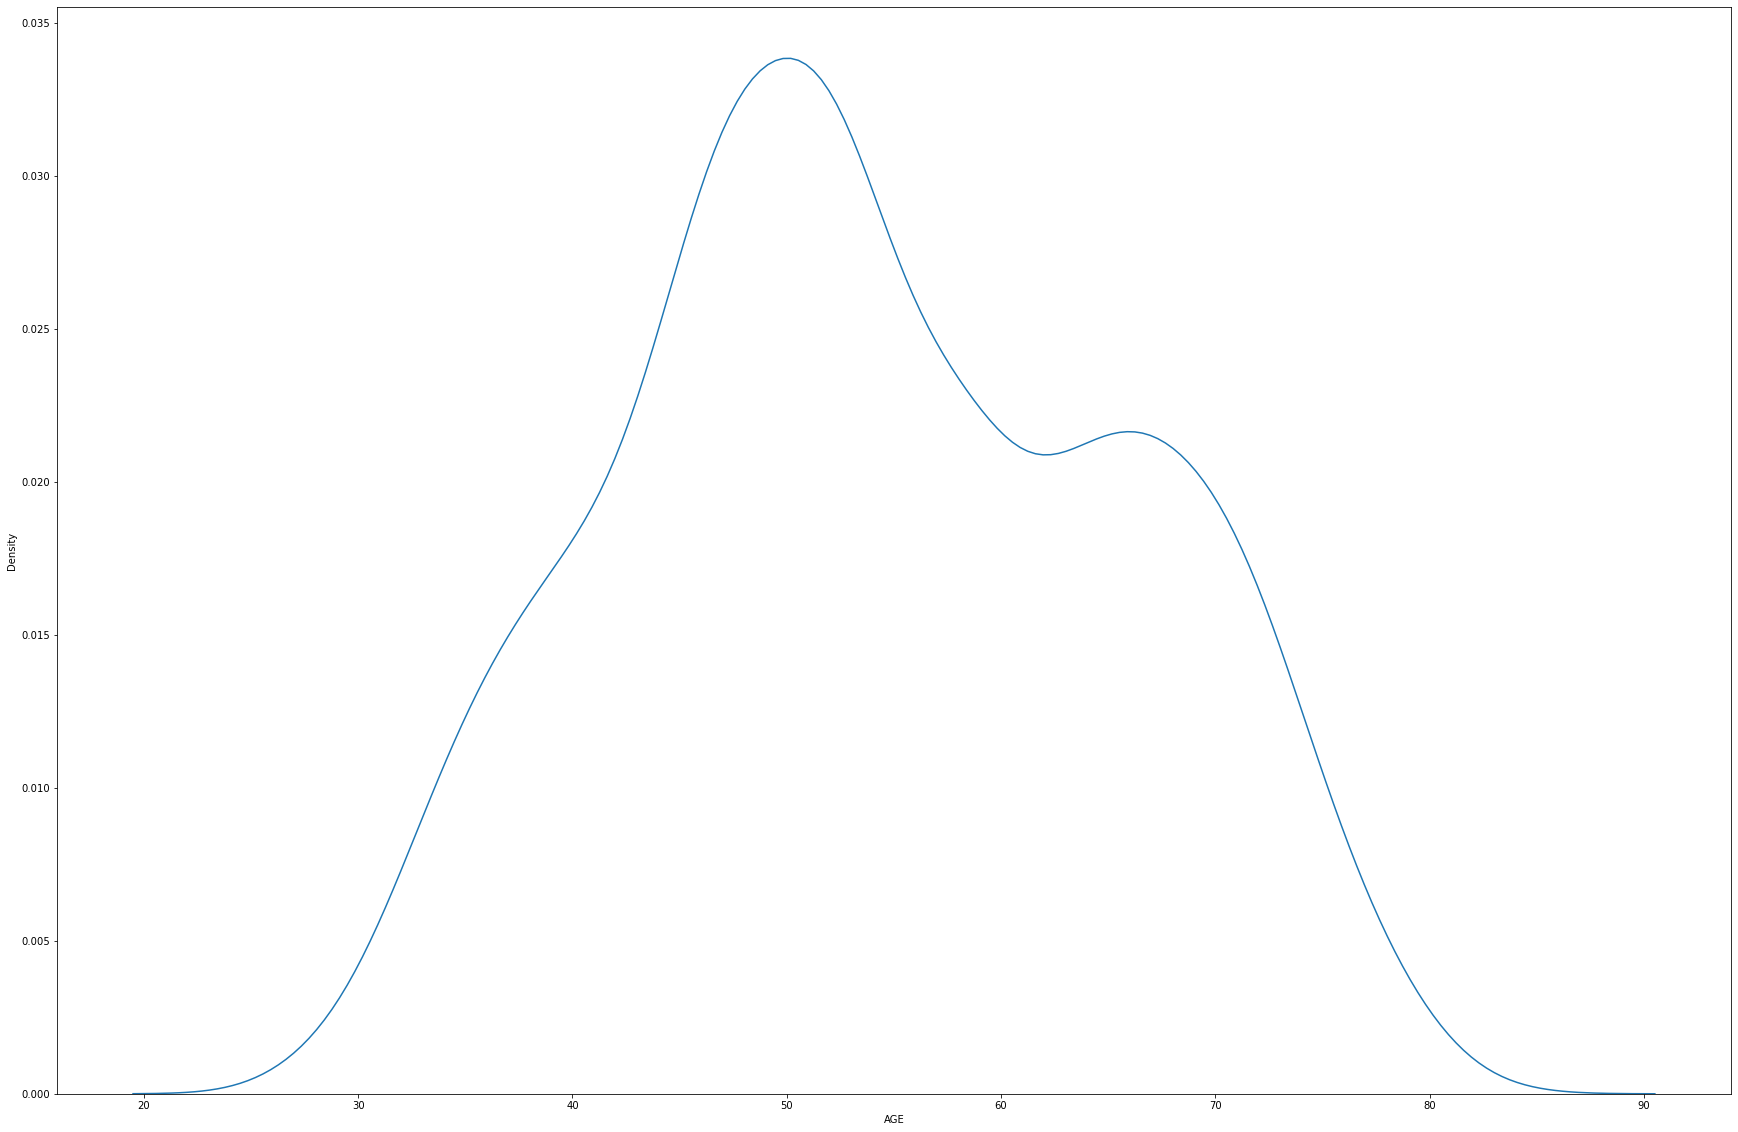

In [12]:
user_info['Year_Birth'] = (2022 - user_info['Year_Birth'] + 1)
user_info.rename(columns = {'Year_Birth' : 'AGE'}, inplace = True)
outlier = user_info.loc[user_info['AGE'] >90].index
user_info.drop(outlier, inplace = True)
sns.kdeplot(user_info['AGE'])

#### 2. 데이터 탐색(Data exploration) 및 피처 엔지니어링(Feature engineering)
***
###### 2. 재구매 소요일수(Recency)와 행사 참여여부(AcceptedCmp1~5, Response), 웹 방문 횟수(NumWebVisitsMonth)를 통해 컬리패스 이용고객을 파악한다.
> 가. 웹 방문 횟수와 행사 참여여부가 높을 수록, 재구매 소요일수가 낮을 수록 컬리에 충성도가 높은 고객이라 판단함.

> 나. 20대와 70대 이상의 고객을 제외하고서는, 대게 행사 참여 횟수가 1회 이상일 때 웹 방문 횟수와 재구매 소요일수가 음의 상관관계를 보인다.

> 다. 즉, 행사 참여 횟수가 1회 이상인 고객들에 대해서 Kurly_Pass 이용자라 판단한다. 

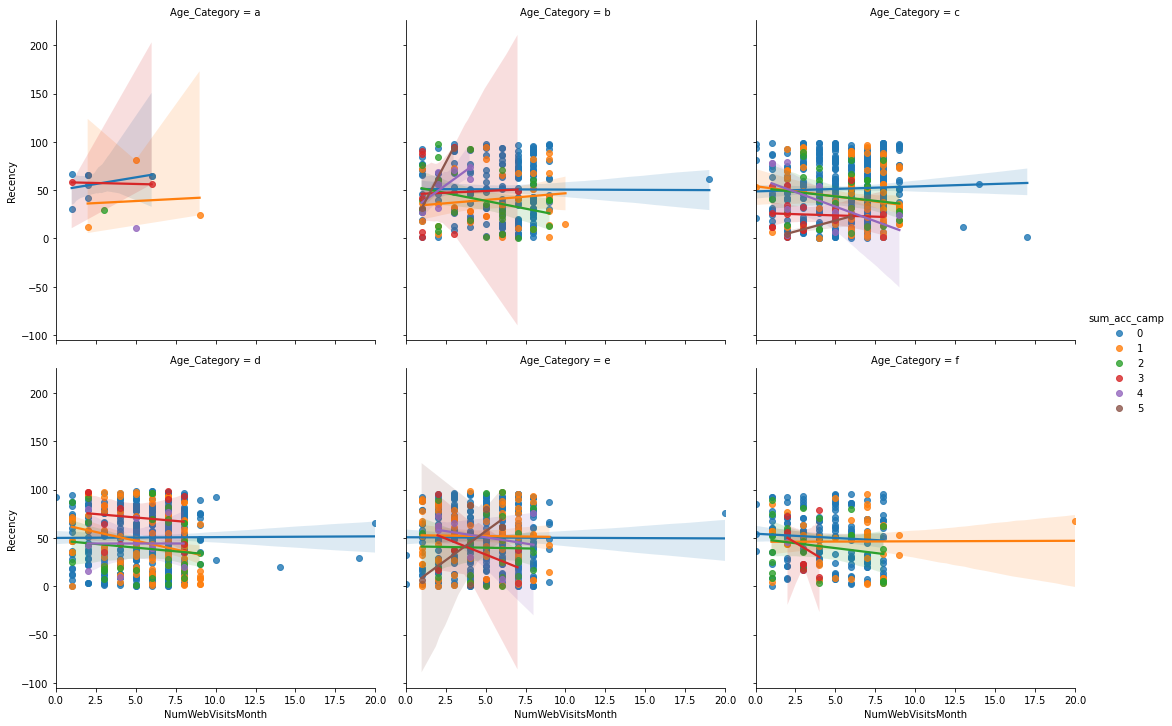

In [13]:
acc_camp = [el for el in user_info.columns if 'Cmp' in el] + ['Response']
user_info['sum_acc_camp'] = user_info[acc_camp].sum(axis=1)
user_info['Age_Category'] = pd.cut(user_info.AGE, bins =[20, 30, 40, 50, 60, 70, 90], labels = ['a','b','c',
                                                                                                'd','e','f'])
sns.lmplot(x='NumWebVisitsMonth', y='Recency', hue = 'sum_acc_camp',col ='Age_Category', 
           col_wrap=3, height=5, data=user_info)
plt.show()

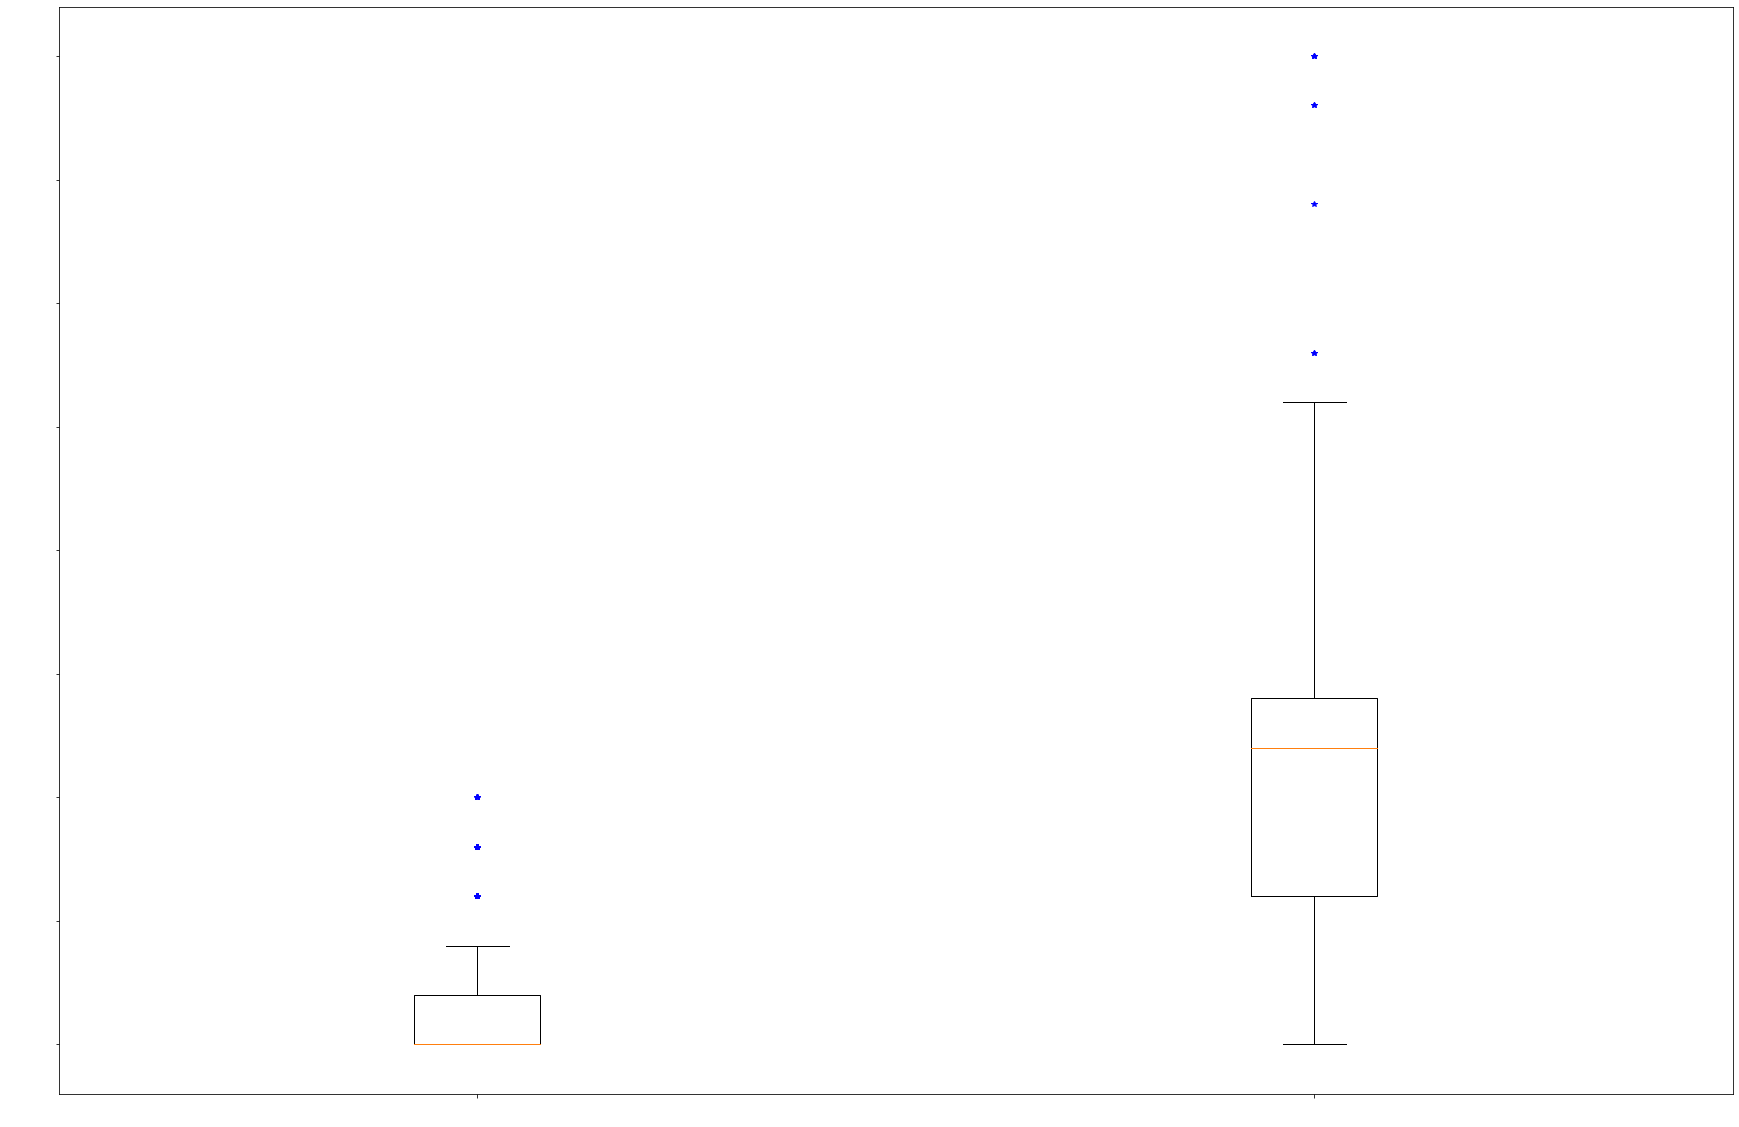

In [14]:
fig, ax = plt.subplots()
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.rcParams["figure.figsize"] = (30,20)
ax.boxplot([user_info['sum_acc_camp'],user_info['NumWebVisitsMonth']], sym="b*")
plt.xticks([1,2], ['campaign','numbwebvisitsmonth'])
plt.show()

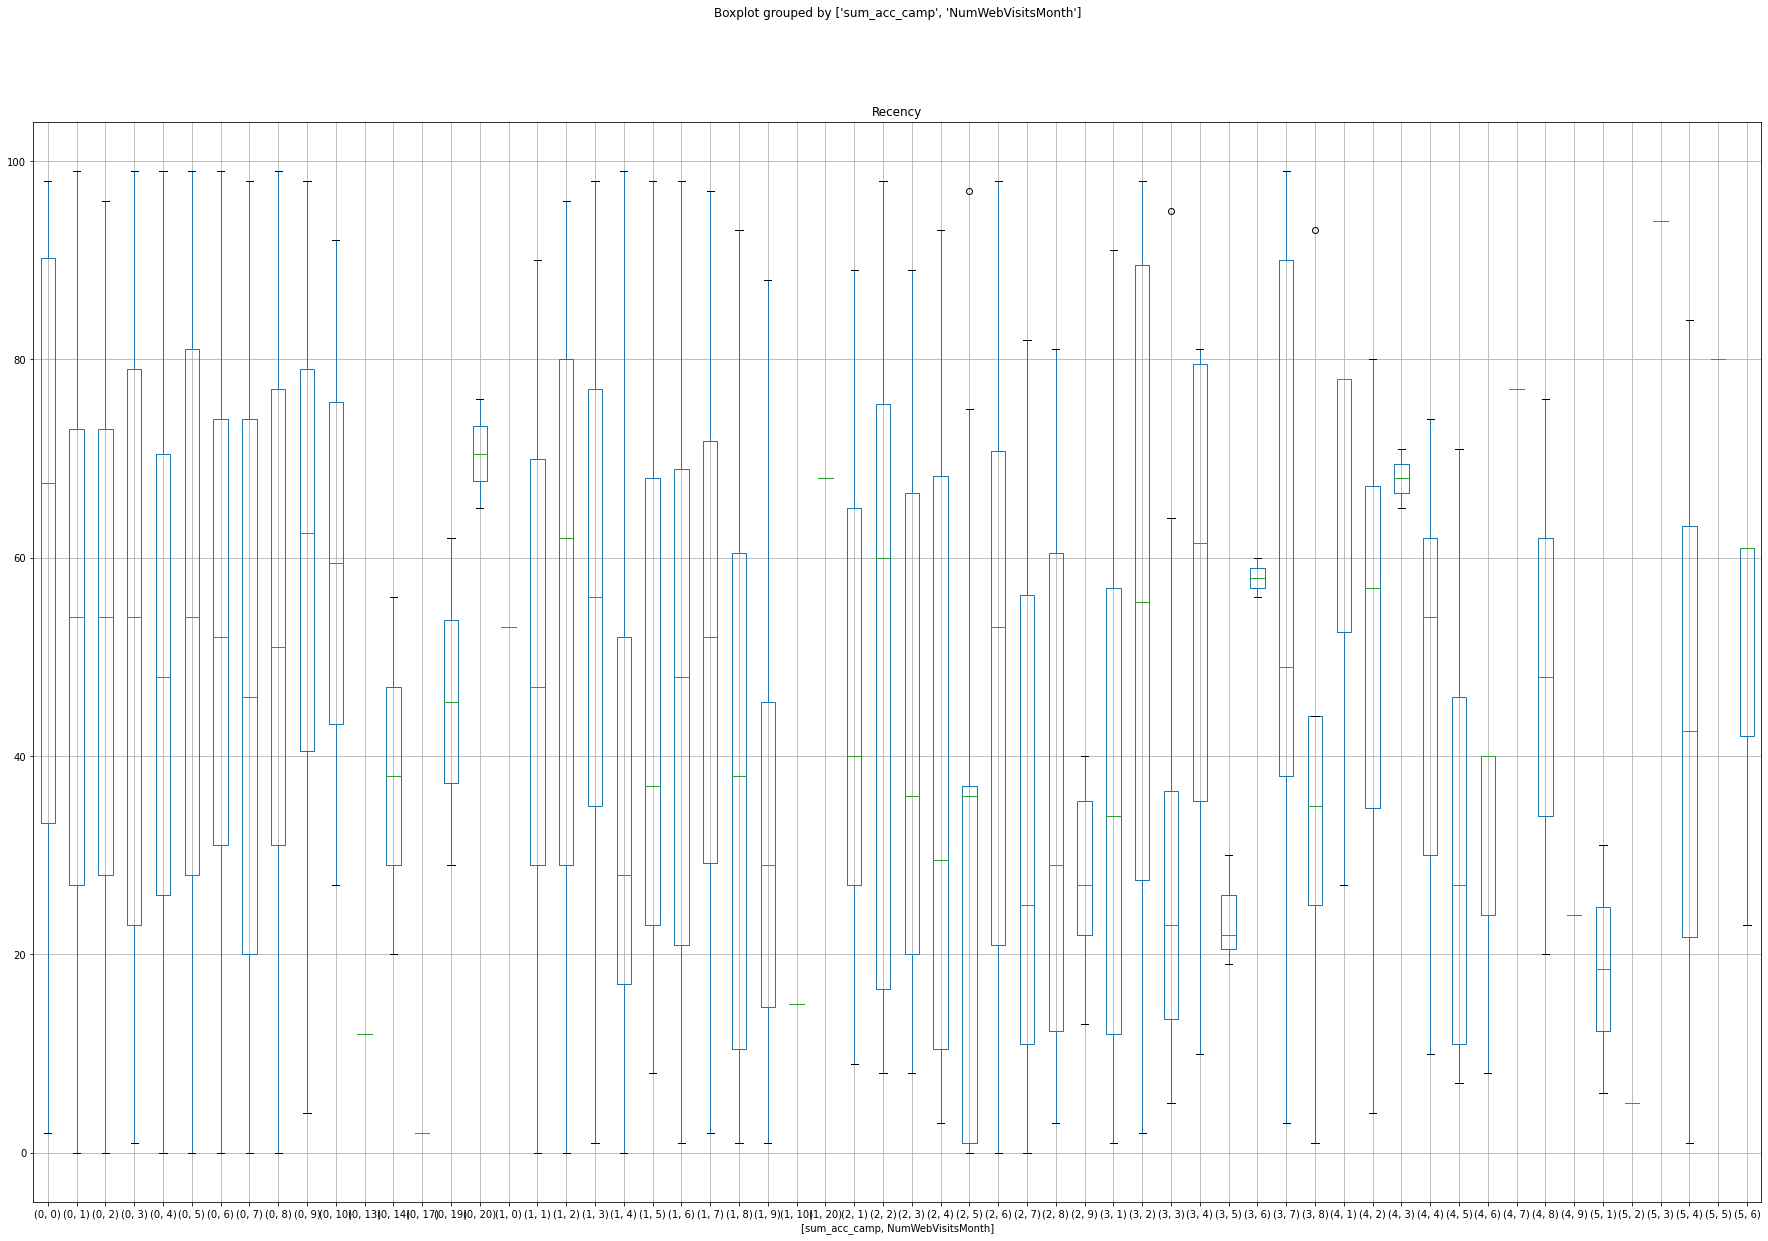

In [15]:
user_info.boxplot(column=["Recency"], by=["sum_acc_camp", "NumWebVisitsMonth"])
plt.show()

In [16]:
user_info['kurly_pass'] = 0
user_info.loc[(user_info['sum_acc_camp'] >=1) & (user_info['Age_Category'] != 'a') & (user_info['Age_Category'] != 'f'), 'kurly_pass'] = 1
user_info['kurly_pass'].value_counts()

0    1708
1     529
Name: kurly_pass, dtype: int64

#### 2. 데이터 탐색(Data exploration) 및 피처 엔지니어링(Feature engineering)
***
###### 3. 잠재 고객 파악 및 고객 타겟팅.
> 가. 20대, 70대 이상 고객은 그 수가 적지만 (구매량/웹페이지 방문 횟수)가 높다. 또한 주 고객층인 40~50대는 (구매량/웹페이지 방문 횟수)가 적다.

> 나. 20대는 행사에 평균 1번 이상 참여하였고, 나머지 고객층은 평균 0.5번정도 참여하였다.

> 다. 잠재성이 높은 20대는 평균 1번 이상 참여로, 나이대별 가장 많이 행사에 참여하지만 6번 중 1번의 수는 낮다고 생각한다. 그러므로 20대에게 더욱 맞는 행사를 개최하고, 고객층중 가장 두터운 40~50대에게는 홈페이지 이용이 용이하지 않을 수 있기에, 앱의 기능을 발전시켜 타겟팅 하는 것이 좋다.

<AxesSubplot:xlabel='Age_Category'>

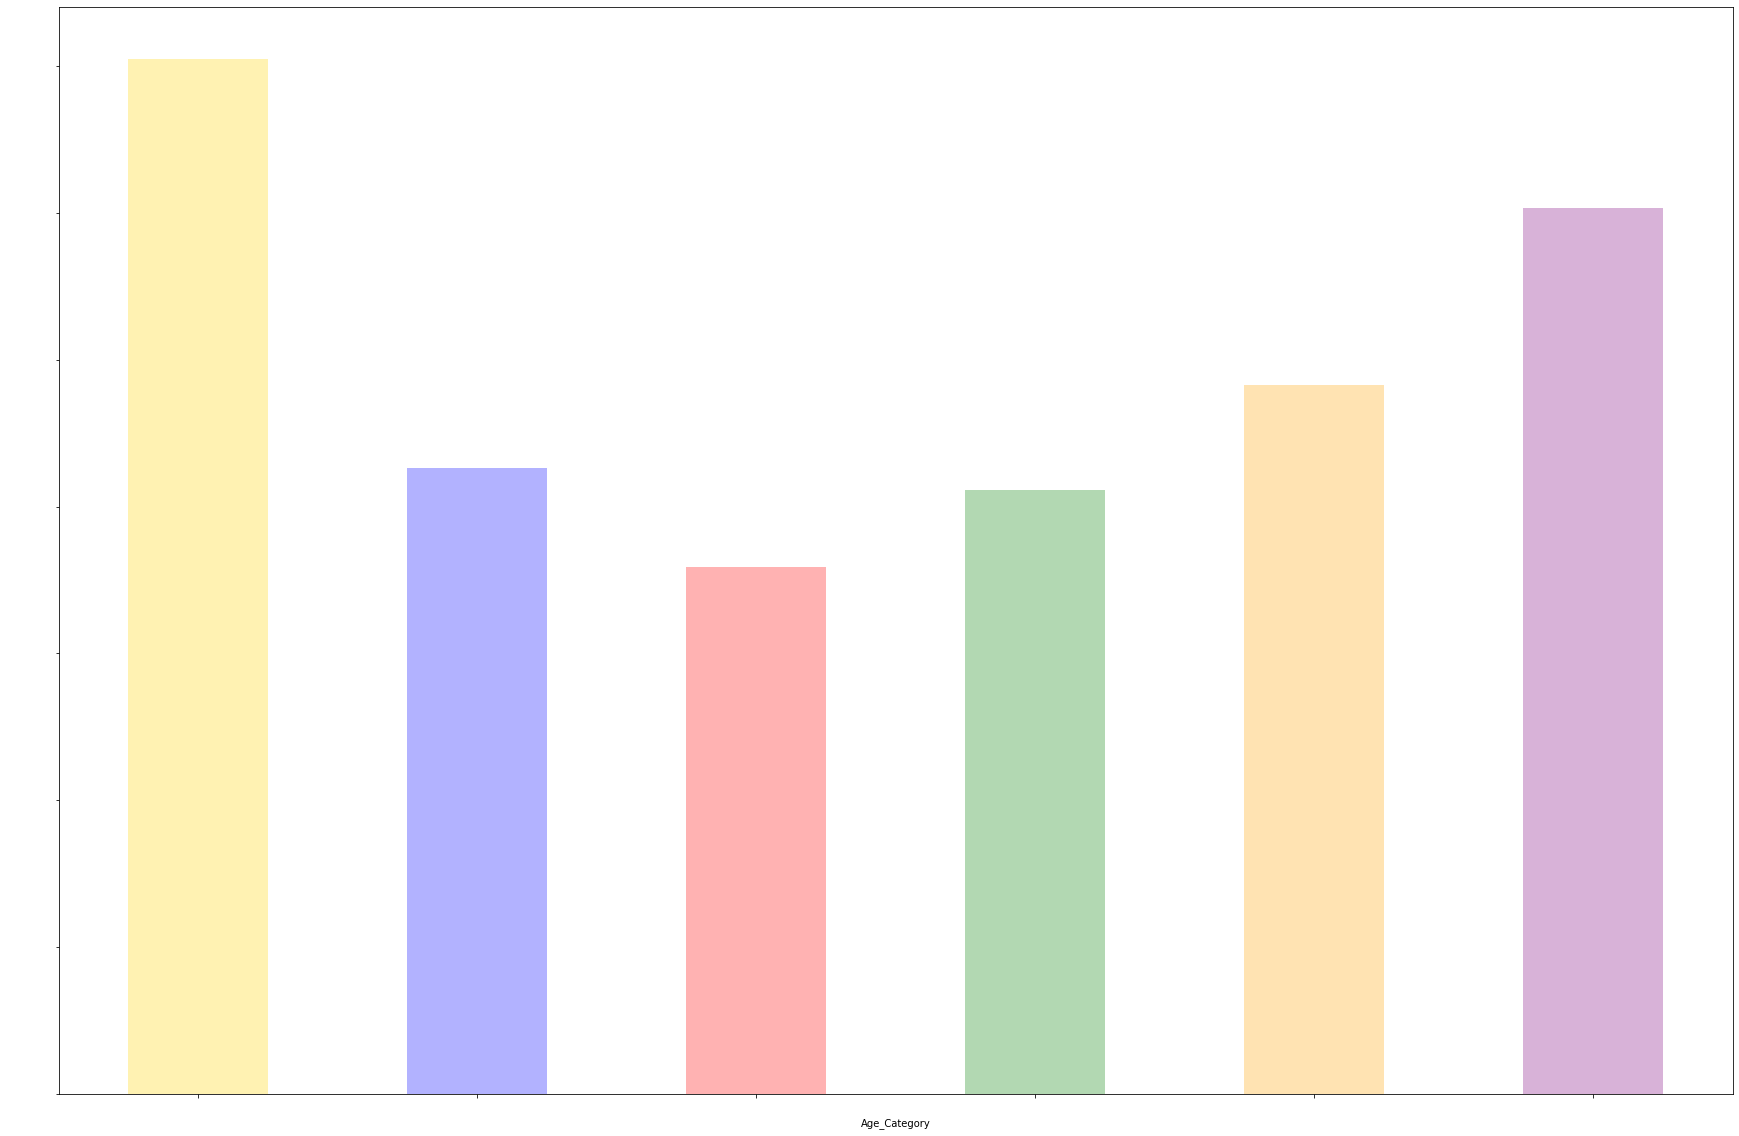

In [17]:
user_info['NumWebVisitsMonth'].isna().sum() # null값은 없음.
user_info['Purchase_Ratio'] = user_info['NumWebPurchases'] / user_info['NumWebVisitsMonth']
user_info['Purchase_Ratio'].replace([np.inf, -np.inf], 0, inplace = True)
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
user_info['Purchase_Ratio'].groupby(user_info['Age_Category']).mean().plot.bar(color = ['gold','b','#FF0000','green','orange','purple'], alpha = 0.3)

<AxesSubplot:xlabel='Age_Category'>

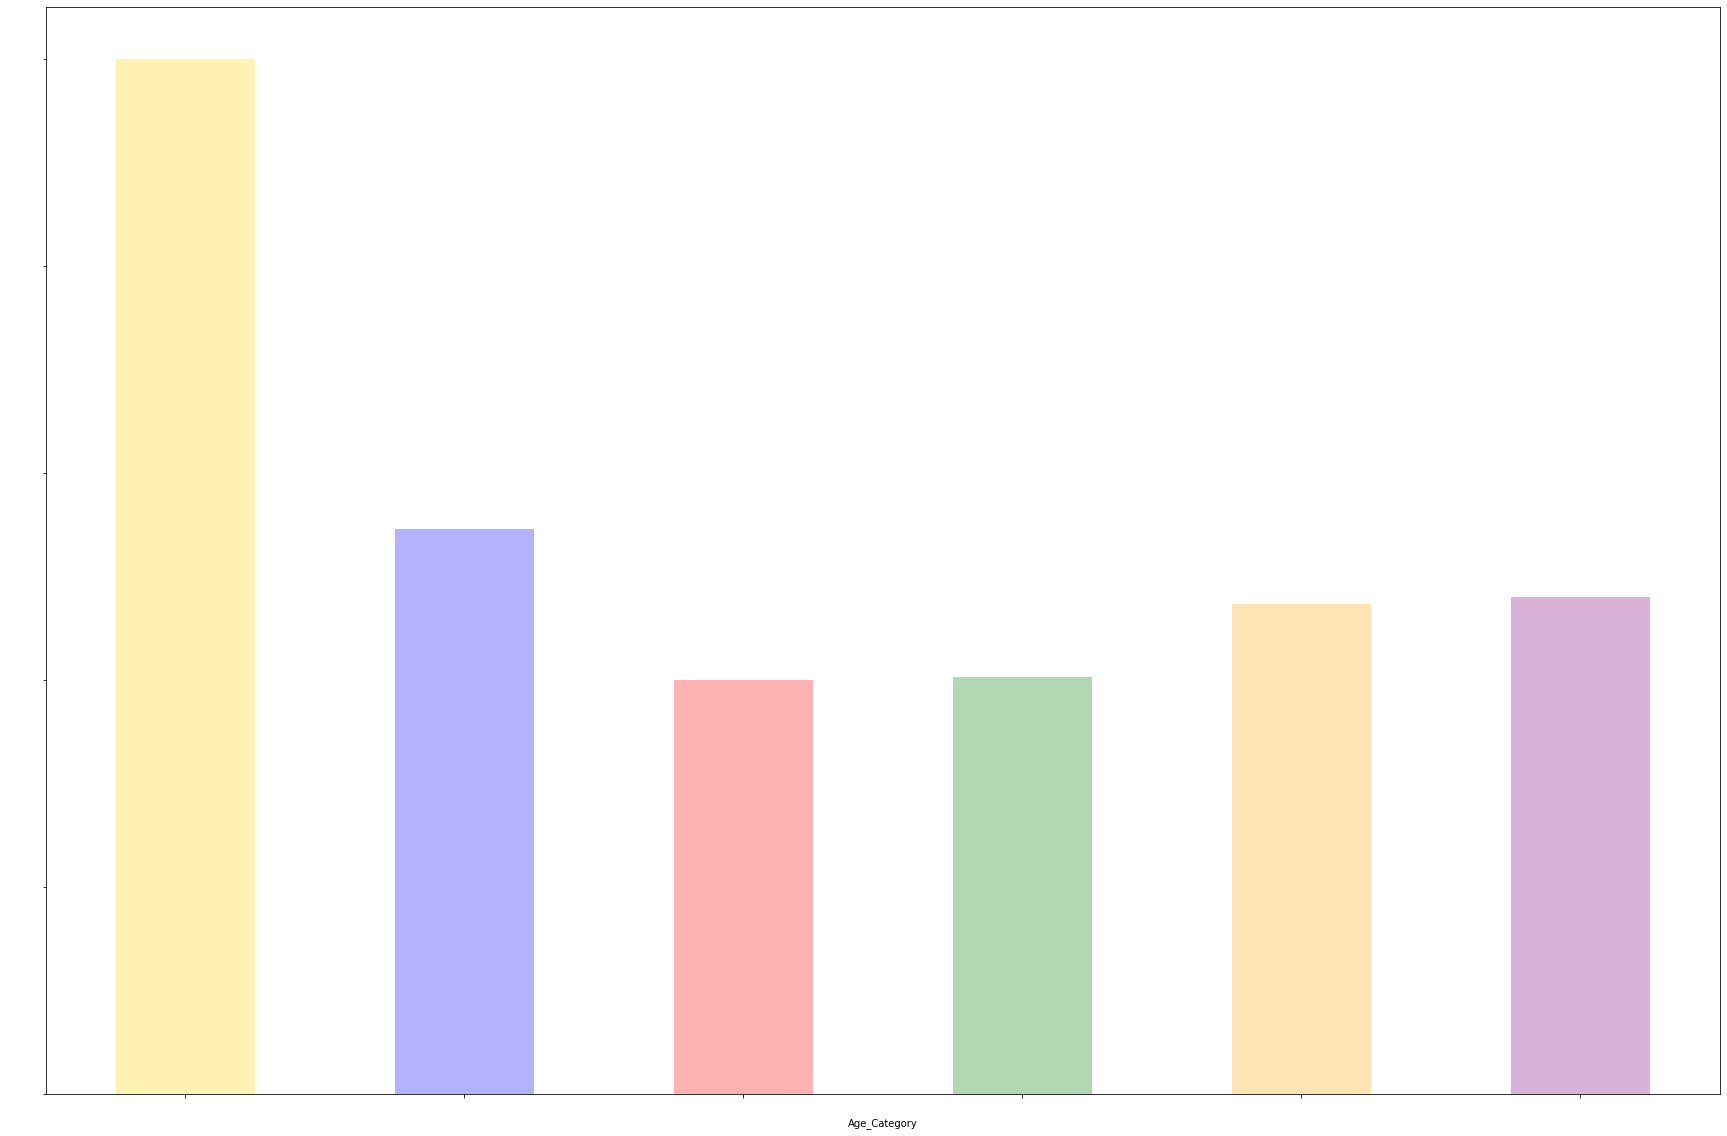

In [18]:
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
user_info['sum_acc_camp'].groupby(user_info['Age_Category']).mean().plot.bar(color = ['gold','b','#FF0000','green','orange','purple'], alpha = 0.3)

#### 3. 데이터 전처리(Preprocessing)
***

In [19]:
user_info.drop(columns = ['AcceptedCmp3','AcceptedCmp4','AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 
                          'Complain', 'Response','Age_Category','Purchase_Ratio','sign_up'], axis =1, inplace = True)                        
merge_user = pd.merge(user_info,click_df, how='right',on='ID')
merge_user.set_index('ID', inplace = True)
merge_user = merge_user.fillna(0)
merge_user['kurly_pass'] = merge_user['kurly_pass'].astype('category')
merge_user_pr = merge_user.copy()

#### 4. 모델링(Modeling)
***
###### 1. PCA와 실루엣 점수로 K-Means 수행하기


In [20]:
# scaler = StandardScaler()
# scale_result = scaler.fit_transform(merge_user)
pca = PCA(n_components = 3)
pca_array = pca.fit_transform(np.array(merge_user))
pca_df = pd.DataFrame(pca_array, index=merge_user.index,
                      columns=[f"pca{num+1}" for num in range(pca_array.shape[1])])
pca_df

,pca1,pca2,pca3
ID,,,
0,136.841513,394.602968,-119.631399
1,90.544925,-171.100571,29.467262
9,-287.117129,-14.977141,21.596638
13,-330.668158,-16.748327,16.391154
17,325.782214,-95.367865,35.382224
...,...,...,...
11178,-331.888324,-10.120519,16.116815
11181,-346.834373,-11.123111,14.170601
11187,-341.604787,-1.504015,-2.231233


In [21]:
result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca.explained_variance_,
             '기여율':pca.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(pca_array.shape[1])]))
result['누적기여율'] = result['기여율'].cumsum()
result

,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,136393.311388,0.792352,0.792352
pca2,29803.147933,0.173136,0.965488
pca3,2597.332445,0.015089,0.980577


In [22]:
def visualize_silhouette(cluster_lists, X_features):
    plt.rcParams["figure.figsize"] = (30,20)
    n_cols = len(cluster_lists) 
    fig, axs = plt.subplots(figsize=(4*n_cols, 2), nrows=1, ncols=n_cols)
    for ind, n_cluster in enumerate(cluster_lists):
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

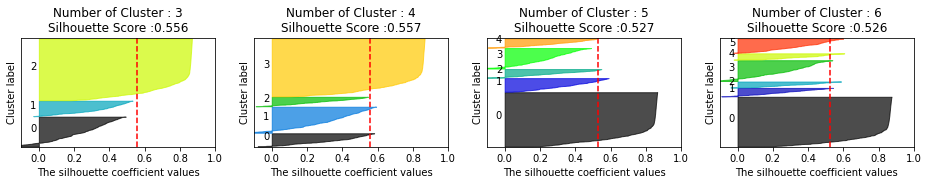

In [23]:
visualize_silhouette([3,4,5,6], np.array(pca_df))

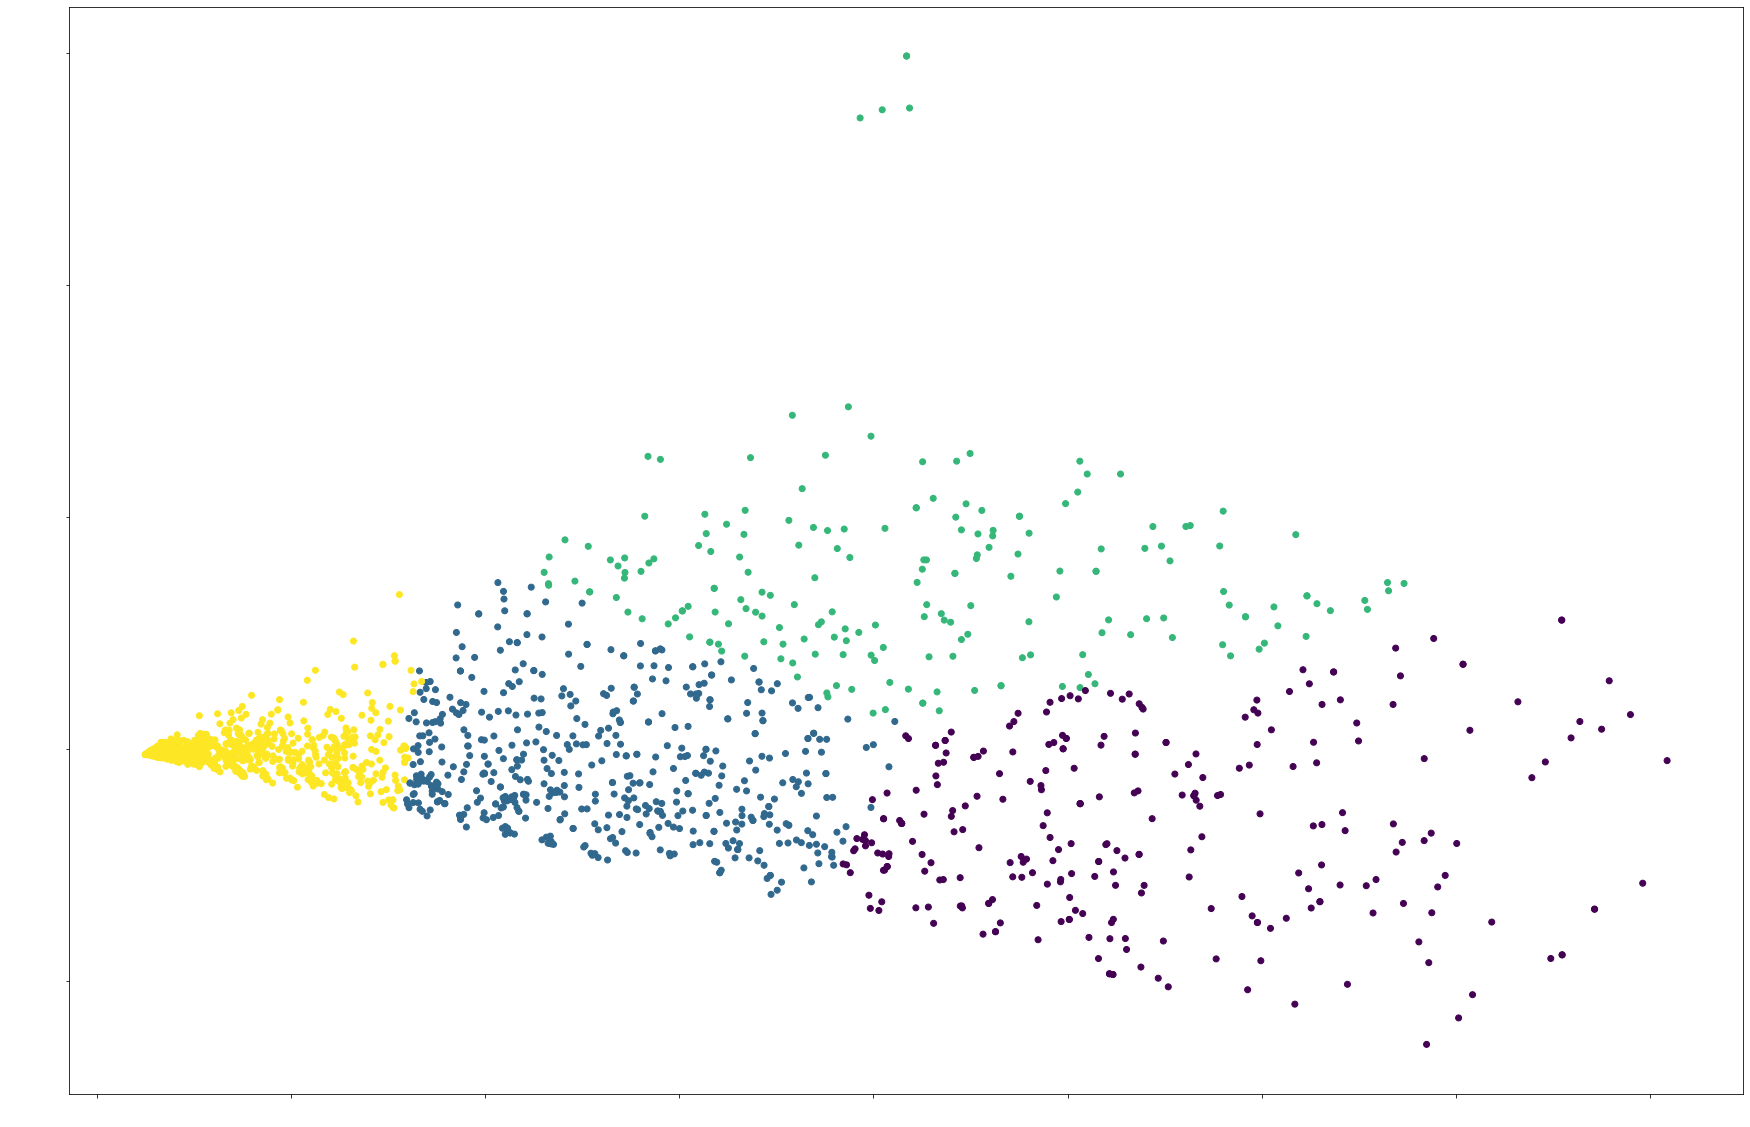

In [24]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(pca_df)
pca_df['cluster'] = kmeans.labels_
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.scatter(x=pca_df['pca1'], y =pca_df['pca2'], c =pca_df['cluster'])

#### 4. 모델링(Modeling)
***
###### 2. PCA + TSNE와 실루엣 점수로 K-Means 수행하기

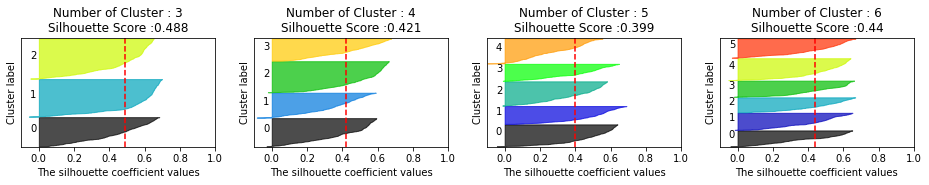

In [25]:
Xtsne = TSNE(n_components=2).fit_transform(pca_df)
dftsne = pd.DataFrame(Xtsne)
visualize_silhouette([3,4,5,6], np.array(dftsne))

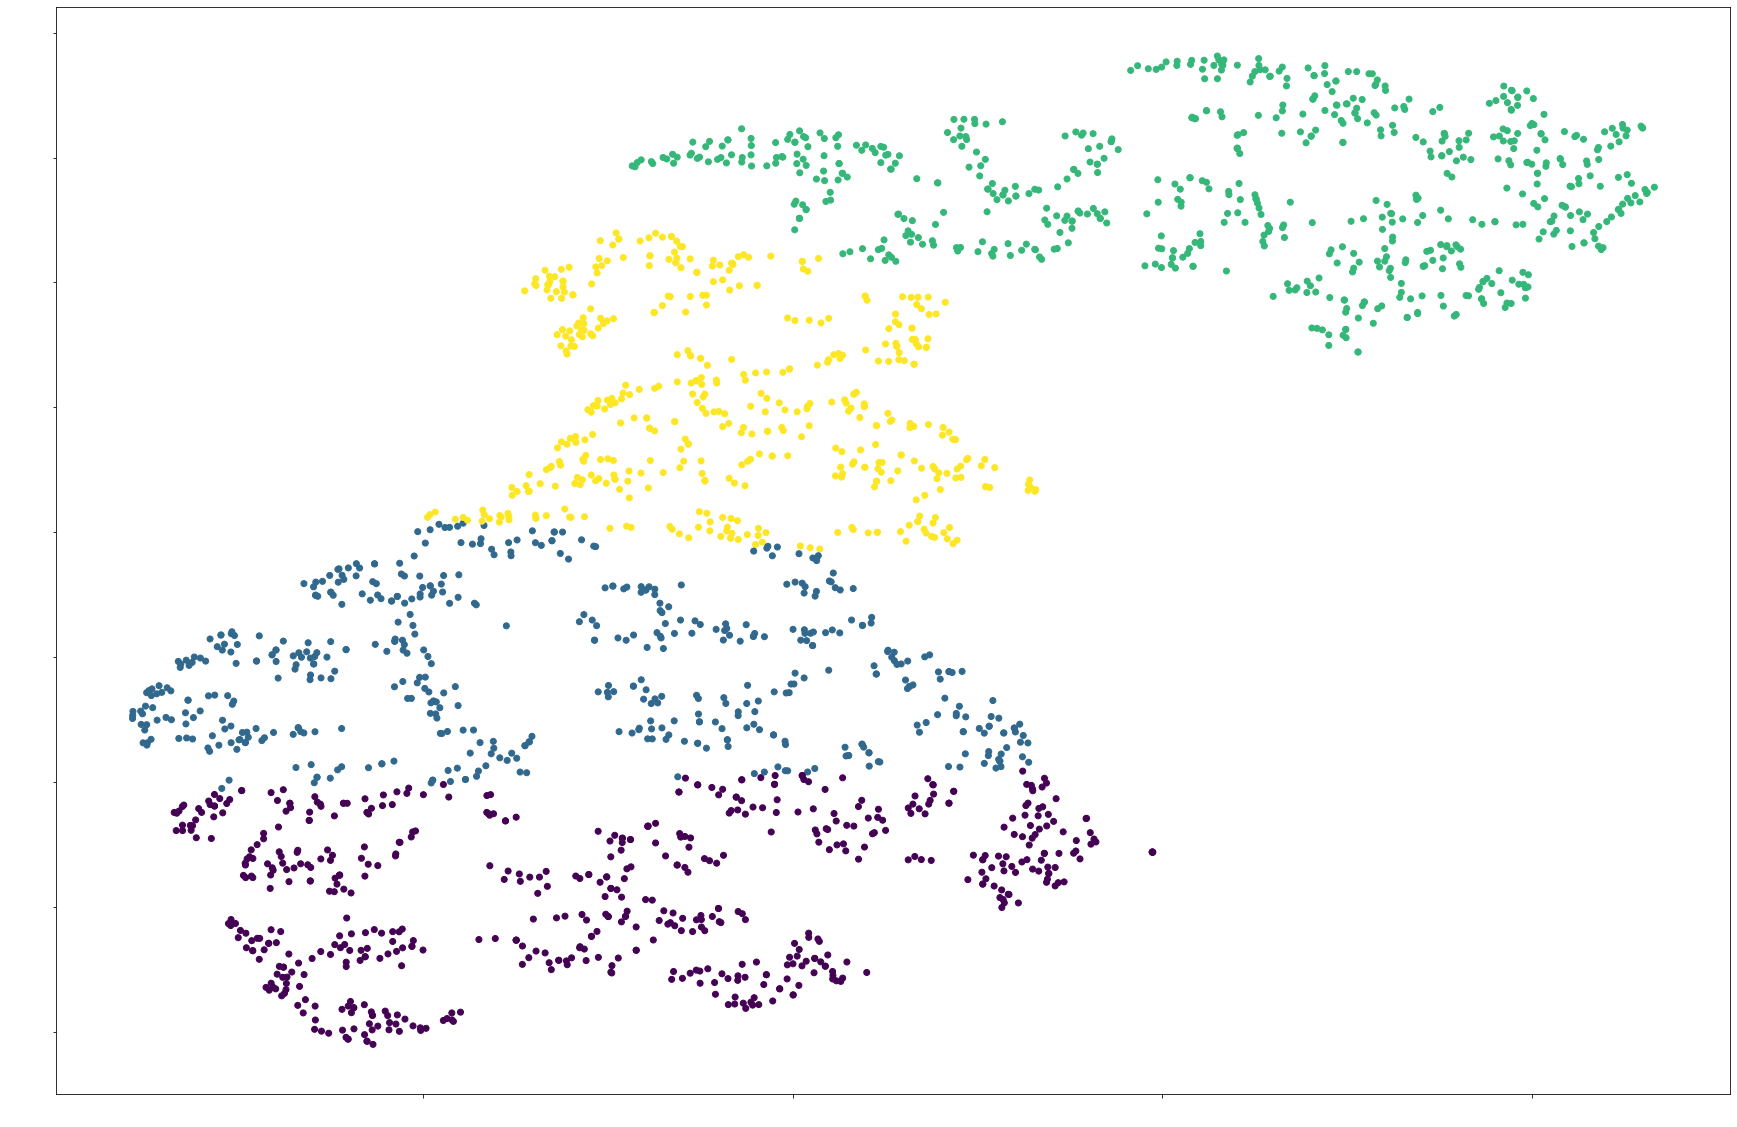

In [26]:
kmeans_tsne = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(Xtsne)
dftsne['cluster2'] = kmeans_tsne.labels_
dftsne.columns = ['tsne1','tsne2','cluster2']
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.scatter(x=dftsne['tsne1'], y =dftsne['tsne2'], c =dftsne['cluster2'])

#### 4. 모델링(Modeling)
***
###### 3. PCA + TSNE + Merge_User(scaler x)와 실루엣 점수로 K-Means 수행하기

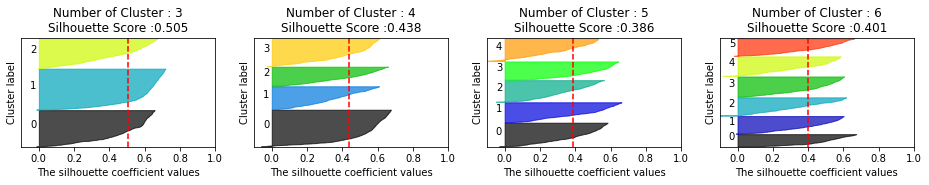

In [27]:
merge_user_pc = merge_user.copy()
merge_user_pc[['pc1','pc2','pc3']] = pca_df.iloc[:,0:3]
X_user_tsne = TSNE(n_components=2).fit_transform(merge_user_pc)
dftsne_user = pd.DataFrame(X_user_tsne)
visualize_silhouette([3,4,5,6], np.array(dftsne_user))

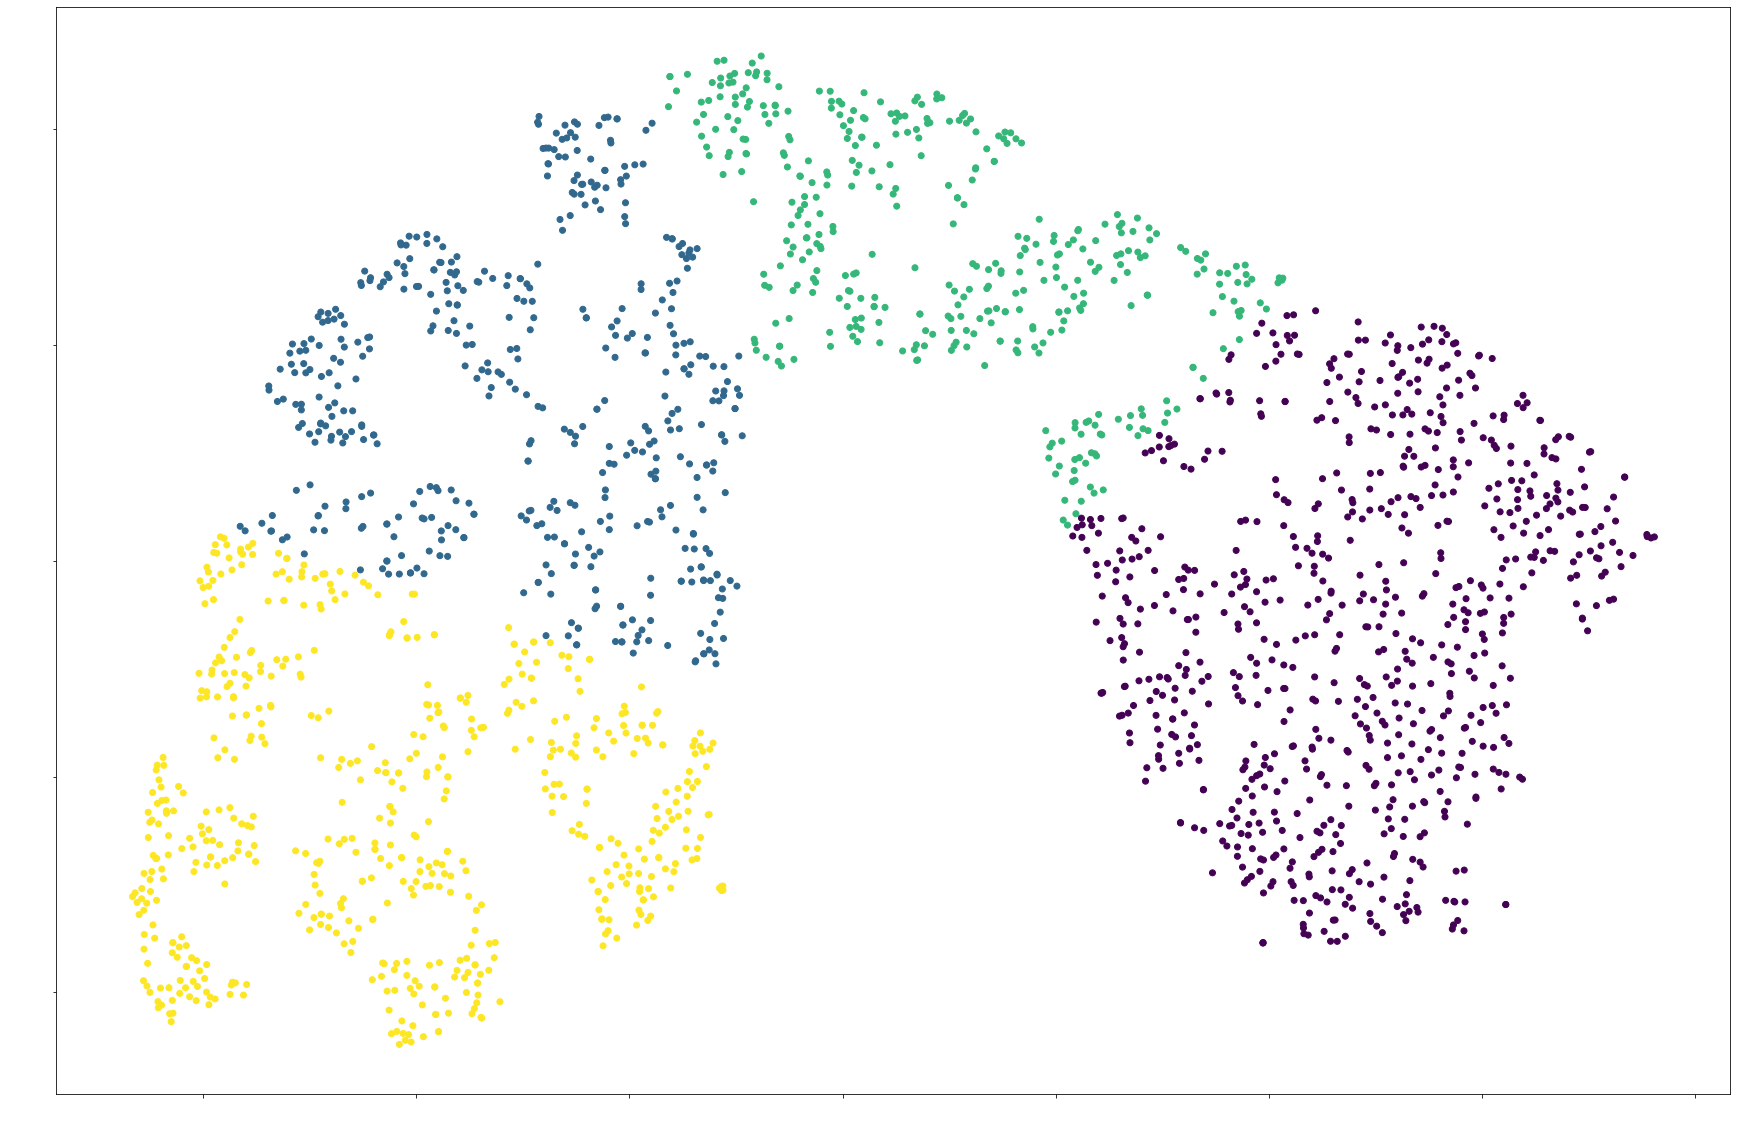

In [28]:
kmeans_tsne_user = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(X_user_tsne)
# dftsne_user.drop(columns = 'cluster2_2', axis = 1, inplace = True)
dftsne_user['cluster3'] = kmeans_tsne_user.labels_
dftsne_user.columns = ['tsne1_1','tsne2_2','cluster2_2']
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.scatter(x=dftsne_user['tsne1_1'], y =dftsne_user['tsne2_2'], c =dftsne_user['cluster2_2'])

#### 4. 모델링(Modeling)
***
###### 4. PCA + TSNE + Merge_User(scaler o)와 실루엣 점수로 K-Means 수행하기

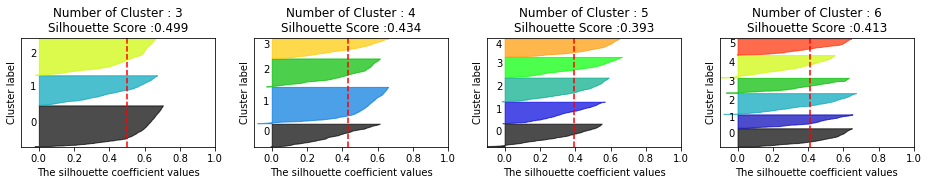

In [29]:
merge_user_pc_scaler = merge_user.copy()
scaler = StandardScaler()
merge_user_pc_scaler_df = pd.DataFrame(data = scaler.fit_transform(merge_user_pc_scaler))
merge_user_pc_scaler[['pc1','pc2','pc3']] = pca_df.iloc[:,0:3]
X_user_tsne_scale = TSNE(n_components=2).fit_transform(merge_user_pc_scaler)
dftsne_user_scale = pd.DataFrame(X_user_tsne_scale)
visualize_silhouette([3,4,5,6], np.array(dftsne_user_scale))

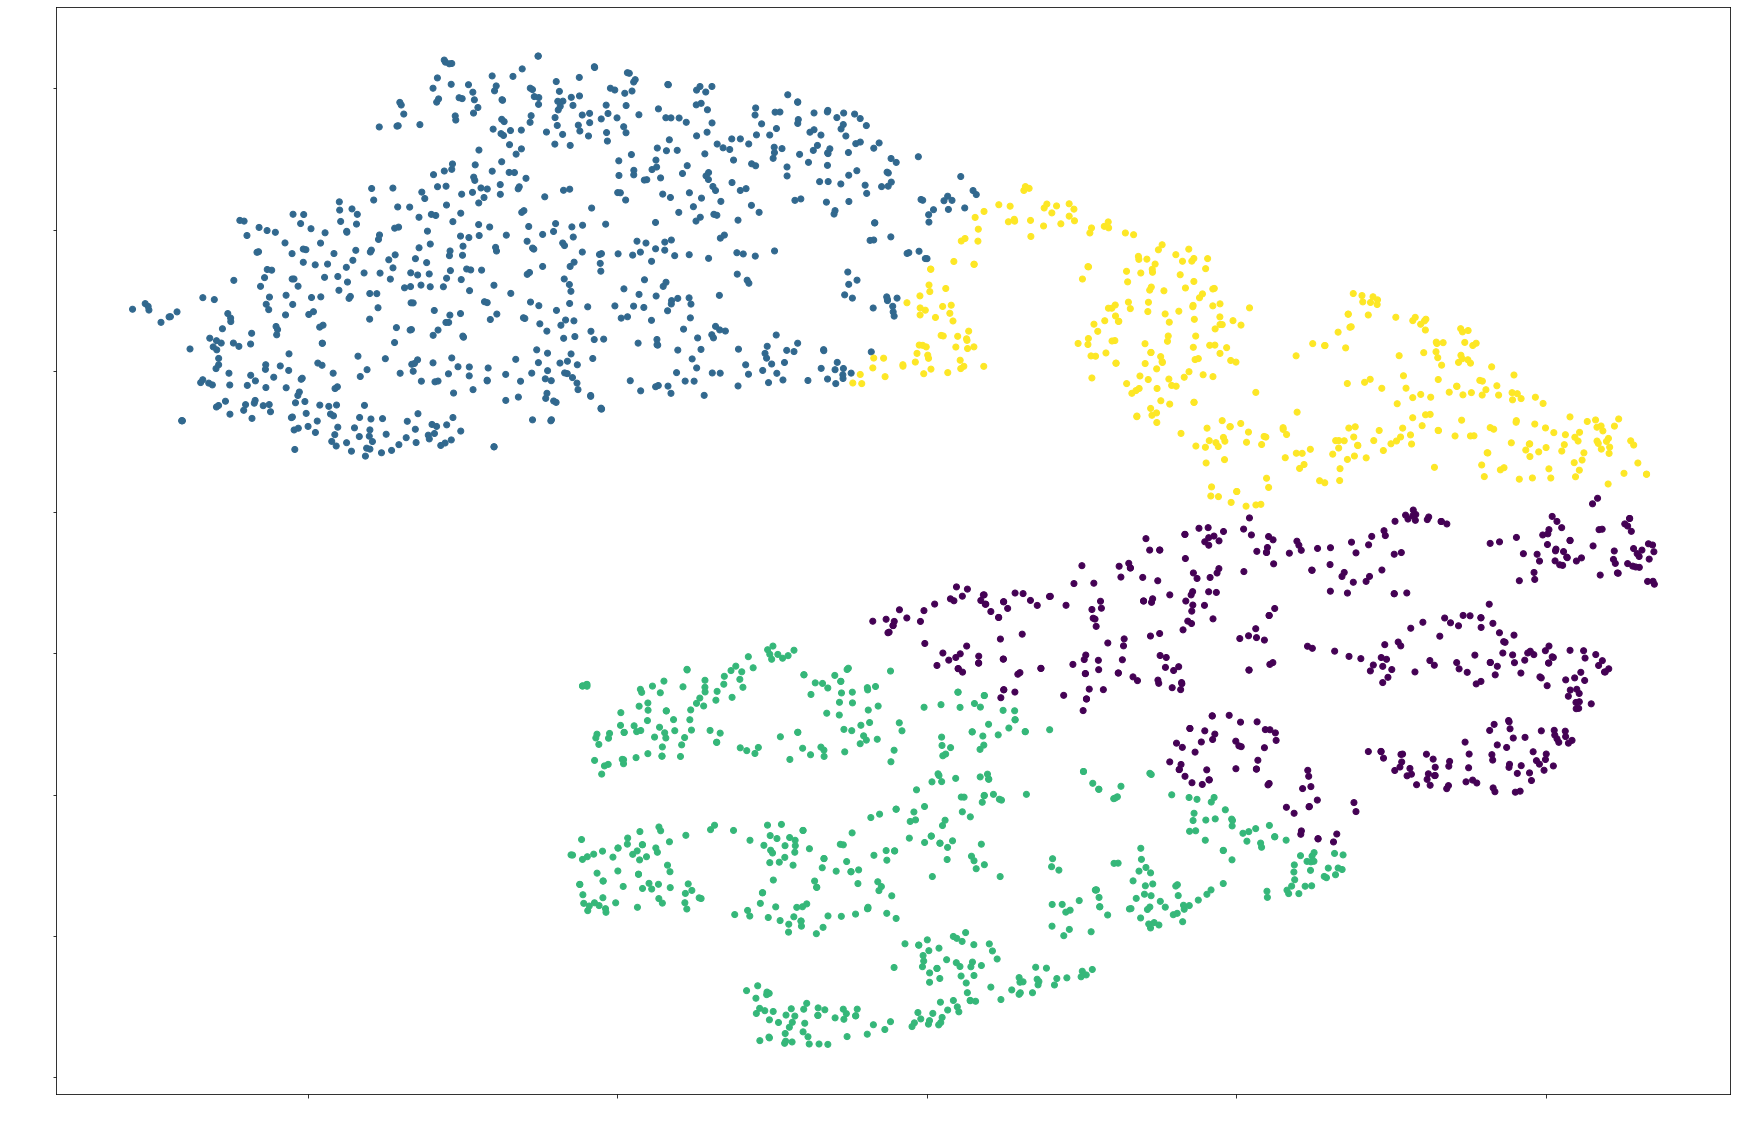

In [30]:
kmeans_tsne_user_scale = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(dftsne_user_scale)
# dftsne_user_scale.drop(columns = 'cluster2_2_2', axis = 1, inplace = True)
dftsne_user_scale['cluster3'] = kmeans_tsne_user_scale.labels_
dftsne_user_scale.columns = ['tsne1_1_1','tsne2_2_2','cluster2_2_2']
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.scatter(x=dftsne_user_scale['tsne1_1_1'], y =dftsne_user_scale['tsne2_2_2'], c =dftsne_user_scale['cluster2_2_2'])

#### 4. 모델링(Modeling)
***
###### 번외. TSNE + user_info와 실루엣 점수로 K-Means 수행하기

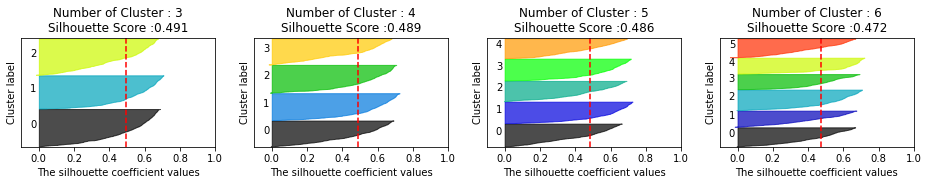

In [31]:
user_info_PCA_TSNE = user_info.copy()
user_info_PCA_TSNE = TSNE(n_components=2).fit_transform(user_info_PCA_TSNE)
user_info_PCA_TSNE_df = pd.DataFrame(user_info_PCA_TSNE)
visualize_silhouette([3,4,5,6], np.array(user_info_PCA_TSNE_df))

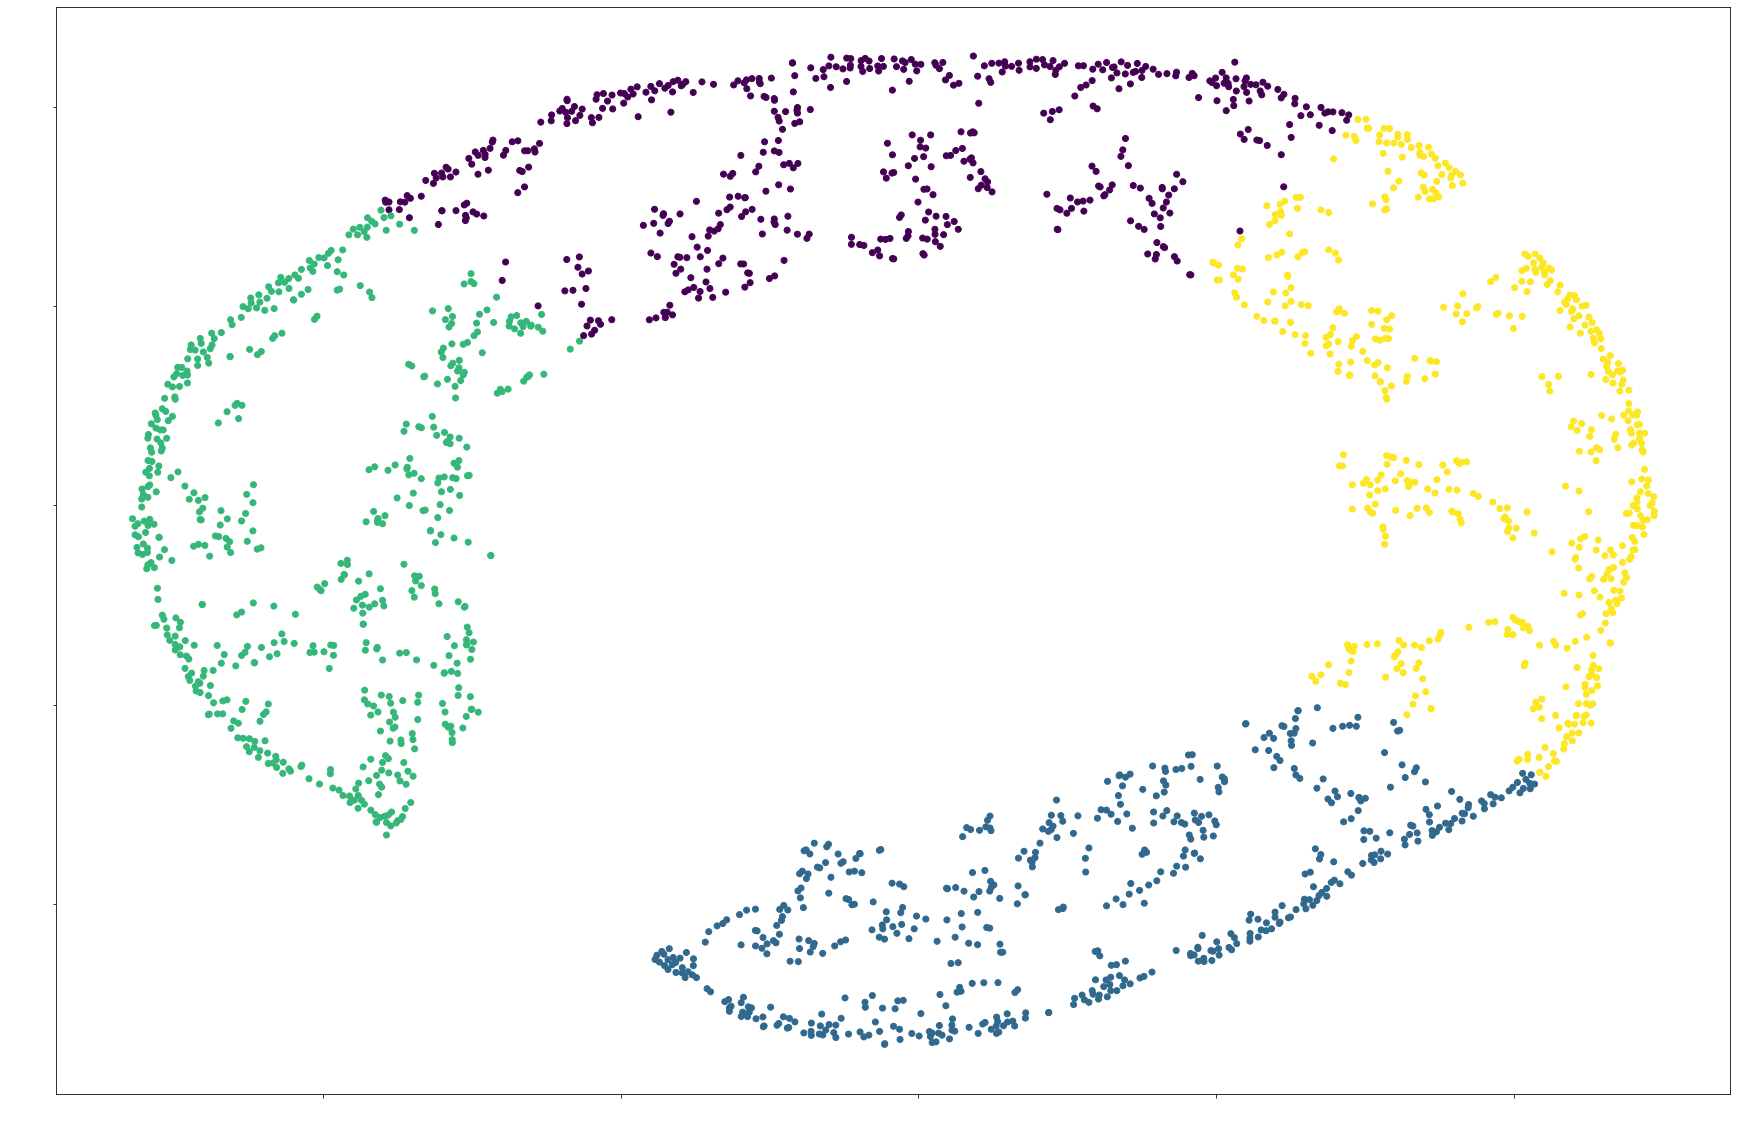

In [32]:
user_info_KMeans = KMeans(n_clusters=4, init='k-means++', max_iter=300,random_state=0).fit(user_info_PCA_TSNE_df)
# dftsne_user_scale.drop(columns = 'cluster2_2_2', axis = 1, inplace = True)
user_info_PCA_TSNE_df['cluster3'] = user_info_KMeans.labels_
user_info_PCA_TSNE_df.columns = ['tsne1_1_1_','tsne2_2_2_','cluster2_2_2_']
plt.xticks(fontsize = 20, color = 'white')
plt.yticks(fontsize = 20, color = 'white')
plt.scatter(x=user_info_PCA_TSNE_df['tsne1_1_1_'], y =user_info_PCA_TSNE_df['tsne2_2_2_'], c =user_info_PCA_TSNE_df['cluster2_2_2_'])

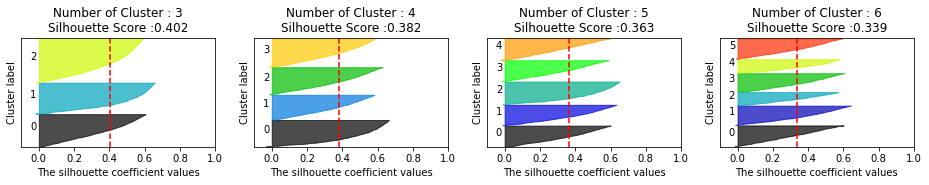

In [33]:
merge_user_pc_scaler[['pc1','pc2','pc3']] = pca_df.iloc[:,0:3]
scaler = StandardScaler()
merge_user_pc_scaler2 = scaler.fit_transform(merge_user_pc_scaler)
X_user_tsne_scale2 = TSNE(n_components=2).fit_transform(merge_user_pc_scaler2)
dftsne_user_scale2 = pd.DataFrame(X_user_tsne_scale2)
visualize_silhouette([3,4,5,6], np.array(dftsne_user_scale2))

#### 4. 모델링(Modeling)
***
###### 결론 : 1번의 user_info + click 데이터에 pca를 결합한 모델의 실루엣 깂이 가장 높게 나왔다. 1번 모델을 토대로 고객들을 4개의 그룹으로 나눈다.

#### 5. 추천 데이터 준비
***
###### > 1번 클러스터링 모델을 통해 클러스터로 그룹을 나누고, 각각의 csv로 저장한다

In [34]:
person_0 = list(pca_df[pca_df['cluster'] == 0].index)
person_1 = list(pca_df[pca_df['cluster'] == 1].index)
person_2 = list(pca_df[pca_df['cluster'] == 2].index)
person_3 = list(pca_df[pca_df['cluster'] == 3].index)
recom_data= pd.DataFrame(click_df.set_index('ID').stack())
recom_data = recom_data.reset_index()
recom_data.columns = ['u_id','p_id','click']
recom_data['p_id'] = recom_data['p_id'].apply(lambda x: int(x))
# recom_data.to_csv('recom_data.csv', header=None)

In [35]:
index_0 = []
for i in person_0:
    for j,x in enumerate(recom_data['u_id']):
        if i == x:
            index_0.append(j)
    recom_data.loc[index_0,:].to_csv('for_person_0_recom.csv', index=False, header=None)

index_1 = []
for i in person_1:
    for j,x in enumerate(recom_data['u_id']):
        if i == x:
            index_1.append(j)
recom_data.loc[index_1,:].to_csv('for_person_1_recom.csv', index=False, header=None)

index_2 = []
for i in person_2:
    for j,x in enumerate(recom_data['u_id']):
        if i == x:
            index_2.append(j)
recom_data.loc[index_2,:].to_csv('for_person_2_recom.csv', index=False, header=None)

index_3 = []
for i in person_3:
    for j,x in enumerate(recom_data['u_id']):
        if i == x:
            index_3.append(j)
recom_data.loc[index_3,:].to_csv('for_person_3_recom.csv', index=False, header=None)

#### 6. 추천 데이터 로드
***
###### > Segmentaion별로 나뉜 고객들의 각 상품에 대한 클릭횟수 데이터를 로드한다. 라이브러리 Surprise 모듈에서만 사용할 수 있는 데이터다.
###### > 한번도 클릭해보지 않은 데이터를 확인하기 위해 위의 데이터를 다른 방식으로 로드한다.

In [36]:
# recom_data[recom_data['click']>0]['p_id'][0:5]
reader0 = Reader(line_format='user item rating', sep=',', rating_scale=(0, 10))
data_folds0 = DatasetAutoFolds(ratings_file='./for_person_0_recom.csv', reader=reader0)
trainset0 = data_folds0.build_full_trainset()

reader1 = Reader(line_format='user item rating', sep=',', rating_scale=(0, 10))
data_folds1 = DatasetAutoFolds(ratings_file='./for_person_1_recom.csv', reader=reader1)
trainset1 = data_folds1.build_full_trainset()

reader2 = Reader(line_format='user item rating', sep=',', rating_scale=(0, 10))
data_folds2 = DatasetAutoFolds(ratings_file='./for_person_2_recom.csv', reader=reader2)
trainset2 = data_folds2.build_full_trainset()

reader3 = Reader(line_format='user item rating', sep=',', rating_scale=(0, 10))
data_folds3 = DatasetAutoFolds(ratings_file='./for_person_3_recom.csv', reader=reader3)
trainset3 = data_folds3.build_full_trainset()

In [37]:
unseen_product_confirm0 = pd.read_csv('./for_person_0_recom.csv')
unseen_product_confirm0.columns = ['u_id','p_id','click']

unseen_product_confirm1 = pd.read_csv('./for_person_1_recom.csv')
unseen_product_confirm1.columns = ['u_id','p_id','click']

unseen_product_confirm2 = pd.read_csv('./for_person_2_recom.csv')
unseen_product_confirm2.columns = ['u_id','p_id','click']

unseen_product_confirm3 = pd.read_csv('./for_person_3_recom.csv')
unseen_product_confirm3.columns = ['u_id','p_id','click']

#### 7. Surprise 모델링
***
######  1. GridSearchCV로 Segmentaion별 SVD의 최적의 파라미터를 찾아낸다.
###### 2. 찾아낸 하이퍼 파라미터로 각각의 모델을 학습시킨다.

In [196]:
reader = Reader(rating_scale=(0,10))
param_grid = {'n_epochs': [20, 40, 60], 'n_factors': [20,30,40] }
def parameter_optimization(trainset, SVD, param_grid):
    data = Dataset.load_from_df(trainset[['u_id','p_id','click']], reader)
    good_para = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
    good_para.fit(data)
    print(good_para.best_score['rmse'])
    print(good_para.best_params['rmse'])
    
parameter_optimization(unseen_product_confirm0, SVD, param_grid)
parameter_optimization(unseen_product_confirm1, SVD, param_grid)
parameter_optimization(unseen_product_confirm2, SVD, param_grid)
parameter_optimization(unseen_product_confirm3, SVD, param_grid)

4.147335974814555
{'n_epochs': 20, 'n_factors': 20}
4.181571539561864
{'n_epochs': 20, 'n_factors': 20}
4.0840405011521055
{'n_epochs': 20, 'n_factors': 20}
4.157528588191392
{'n_epochs': 20, 'n_factors': 20}


In [39]:
algo0 = SVD(n_epochs=20, n_factors=20, random_state=0)
algo0.fit(trainset0)

algo1 = SVD(n_epochs=20, n_factors=20, random_state=0)
algo1.fit(trainset1)

algo2 = SVD(n_epochs=20, n_factors=20, random_state=0)
algo2.fit(trainset2)

algo3 = SVD(n_epochs=20, n_factors=20, random_state=0)
algo3.fit(trainset3)

#### 8. 모델링 결과 CSV로 배포
***
######  1. 각 Segmentation 별 고객들의 한번도 클릭하지 않았던 데이터를 상위 10개 추출한다.
###### 2.  모든 영역의 고객의 데이터를 CSV로 저장하고 모든 고객에게 추천할 상품을 나열한다.

In [40]:
product = pd.read_csv('./상품 데이터.csv', encoding = 'ANSI')
def recommen_for_unseen_products(person_recom,product, algo, userId):
    a = person_recom[person_recom['u_id'] ==userId]
    unseen_product = a[a['click']==0]['p_id']
    algo_predict = [algo.predict(str(userId), str(unseen)) for unseen in unseen_product]
    def sortkey_est(pred):
        return pred.est
    algo_predict.sort(key=sortkey_est, reverse = True)
    top_product_ids = [ int(pred.iid) for pred in algo_predict]
    top_product_click = [ pred.est for pred in algo_predict]
    top_product_names = product[product.id.isin(top_product_ids)]['product_name']
    top_product_preds = [ (id, names, click) for id, names, click in zip(top_product_ids, top_product_names, top_product_click)]
    return list(top_product_preds[:10])

recommen_for_unseen_products(unseen_product_confirm0, product, algo0, 146)

[(57, '[덴마크] 인포켓 치즈 오리지널', 5.248671308976013),
 (19, '[라라스윗] 생우유 모나카 (140ml * 4개입)', 3.971628371786849),
 (11, '[워커힐] 명월관 갈비탕', 3.28238126967427),
 (10, '[대구 반할만떡] 유부호만두', 3.1474554048913346),
 (43, '[KF365] 한돈 삼겹살 구이용 600g (냉장)', 2.26608508443125),
 (12, '[농심] 신라면컵 6입', 1.6930472635221898),
 (3, '[고온어다이어트] 시즌3 도시락 5종', 1.577843623941873),
 (4, '[허닭] 닭가슴살 큐브 9종 (4개입)', 0.7924130755508263),
 (61, '[Better me] 닭가슴살 큐브 6종 (3개입)', 0.6243885923123749)]

In [41]:
def unseen_product_recom(pdframe, algo):
    hi = [[0]*10 for _ in range(len(pdframe['u_id'].unique()))]
    df = pd.DataFrame(data = hi)
    df.index = pdframe['u_id'].unique()
    for i in range(len(df)):
        array = recommen_for_unseen_products(pdframe, product, algo, pdframe['u_id'].unique()[i])
        for j in range(len(array)):
            df.iloc[i,j]= array[j][0]
    return df

db_table0 = unseen_product_recom(unseen_product_confirm0, algo0)
db_table1 = unseen_product_recom(unseen_product_confirm1, algo1)
db_table2 = unseen_product_recom(unseen_product_confirm2, algo2)
db_table3 = unseen_product_recom(unseen_product_confirm3, algo3)

db_table0.to_csv('db_table0.csv')
db_table1.to_csv('db_table1.csv')
db_table2.to_csv('db_table2.csv')
db_table3.to_csv('db_table3.csv') 